# SPGR

In [1]:
from multiprocessing import set_start_method
set_start_method('forkserver')

In [2]:
import version_control

Last run on cashlab03-deb at 2015-04-29 16:59:53.512931

Phypno Version: 5fd34bdecf40bf72accfd82aba7495eba94acafb

Babel==1.3, Cython==0.22, Jinja2==2.7.3, Markdown==2.6.2, MarkupSafe==0.23, Pillow==2.8.1, PyOpenGL==3.1.0, Pygments==2.0.2, Sphinx==1.3.1, alabaster==0.7.3, bash-kernel==0.3, beautifulsoup4==4.3.2, biopython==1.65, certifi==2015.04.28, coverage==3.7.1, decorator==3.4.2, docutils==0.12, easydev==0.8.3, ipython==3.1.0, jedi==0.9.0, jsonschema==2.4.0, matplotlib==1.4.3, memory-profiler==0.32, mistune==0.5.1, networkx==1.9.1, nibabel==2.0.0, nitime==0.5, nltk==3.0.2, nose==1.3.6, numpy==1.9.2, numpydoc==0.5, ordereddict==1.1, pandas==0.16.0, pandocfilters==1.2.4, pep8==1.6.2, pexpect==3.3, pockets==0.2.4, psutil==2.2.1, ptyprocess==0.4, pycurl==7.19.5.1, pyflakes==0.8.1, pyparsing==2.0.3, pyqtgraph==0.9.10, python-dateutil==2.4.2, python-igraph==0.7.1-4, pytz==2015.2, pyzmq==14.6.0, requests==2.6.2, rope-py3k==0.9.4-1, rpy2==2.5.6, scikit-learn==0.16.1, scipy==0.15.1, six==1.

## Spindle Properties: Descriptive

In [3]:
from spgr.constants import IMAGES_PATH

In [4]:
images_dir = IMAGES_PATH.joinpath('property_descriptive')
if not images_dir.exists():
    images_dir.mkdir()

In [8]:
from spgr.constants import (HEMI_SUBJ,
                            CHAN_TYPE,
                            DATA_OPTIONS,
                            SPINDLE_OPTIONS,
                            )
from spgr.read_data import get_data
from spgr.detect_spindles import get_spindles
from spgr.spindle_source import get_morph_linear, get_chan_with_regions
from spgr.plot_spindles import plot_surf
from spgr.lmer_stats import lmer, lg

from logging import INFO
lg.setLevel(INFO)

In [9]:
from IPython.display import display

In [10]:
def get_spindle_param(subj, param, ref):
    """Param: 'density', 'duration', 'peak_freq', 'peak_val'"""
    spindles = get_spindles(subj, chan_type=CHAN_TYPE, reref=ref, **SPINDLE_OPTIONS)
    
    if param == 'density':
        data = get_data(subj, 'sleep', chan_type=CHAN_TYPE, reref=ref, **DATA_OPTIONS)
        chan = data.attr['chan']

        dat_count = spindles.to_data('count')
        n_min = (data.number_of('trial') * (data.axis['time'][0][-1] - data.axis['time'][0][0])) / 60
        values = dat_count.data[0] / n_min
    
    elif param == 'duration':
        for one_spindle in spindles.spindle:
            one_spindle['duration'] = one_spindle['end_time'] - one_spindle['start_time']
        data = spindles.to_data('duration')
        values = data.data[0]
    else:
        data = spindles.to_data(param)
        values = data.data[0]

    return values

In [11]:
def add_to_dataframe(df, subj, values, chan):

    for one_chan, one_value in zip(chan.chan, values):
        region = one_chan.attr['region']
        if region[:3] == 'ctx':
            df['subj'].append(subj)
            df['region'].append(region[7:])
            df['elec'].append(one_chan.label)
            df['value'].append(one_value)

In [13]:
def plot_average_values(REF):
    lg.propagate = False
    for param in ('density', 'duration', 'peak_val', 'peak_freq'):

        if param == 'density':
            threshold = 0.01, None
            limits = 0, 2
        elif param == 'duration':
            threshold = 0.5, 2
            limits = 1, 1.5
        elif param == 'peak_val':
            threshold = 0.001, None 
            limits = 0, 70
        elif param == 'peak_freq':
            threshold = SPINDLE_OPTIONS['frequency']
            limits = 11, 13

        morphed = []

        dataframe = {'subj': [], 'region': [], 'elec': [], 'value': []}
        
        for subj in HEMI_SUBJ:
            values = get_spindle_param(subj, param, REF)    
            morphed.append(get_morph_linear(subj, values, REF))

            chan = get_chan_with_regions(subj, REF)
            add_to_dataframe(dataframe, subj, values, chan)            
        
        lg.propagate = True
        lmer(dataframe)
        lg.propagate = False
        v = plot_surf(morphed, threshold=threshold, limits=limits)
        v.save(str(images_dir.joinpath('{}_{}.png'.format(param, REF))))
        display(v)
        
    lg.propagate = True

### Reference to Average

/home/gio/tools/phypno/phypno/attr/anat.py:84: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  pos[2] + neighb[p, 2]]
INFO:lmer:LMER summary
INFO:lmer:inferiortemporal               coef=0.547  p=0.0021
INFO:lmer:middletemporal                 coef=0.738  p=0.0371
INFO:lmer:                               coef=0.917
INFO:lmer:caudalmiddlefrontal            coef=1.209  p=0.0371
INFO:lmer:parstriangularis               coef=1.216  p=0.0371
INFO:lmer:rostralmiddlefrontal           coef=1.329  p=0.0000


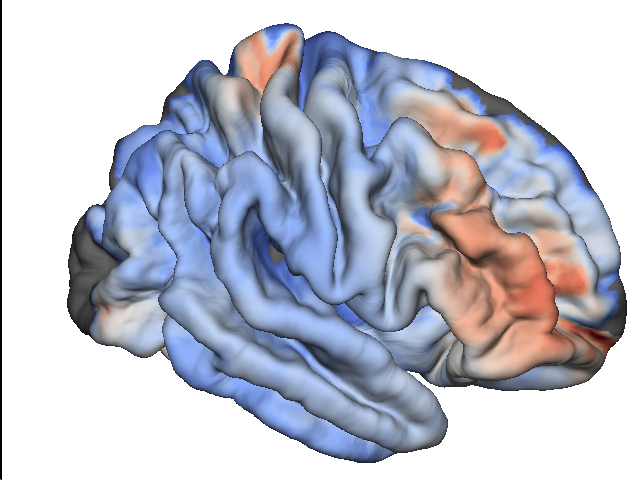

INFO:lmer:LMER summary
INFO:lmer:                               coef=1.274
INFO:lmer:precentral                     coef=1.339  p=0.0003
/home/gio/projects/spgr/scripts/spgr/plot_spindles.py:81: RuntimeWarning: invalid value encountered in greater
  x.data[0][x.data[0] > threshold[1]] = NaN


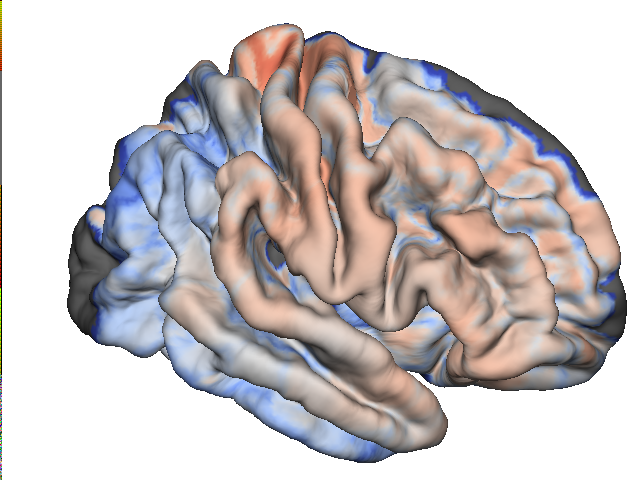

INFO:lmer:LMER summary
INFO:lmer:                               coef=49.810
INFO:lmer:medialorbitofrontal            coef=97.134  p=0.0000


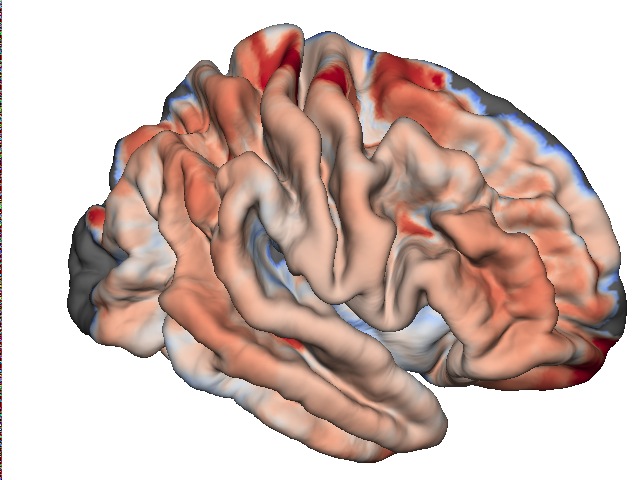

INFO:lmer:LMER summary
INFO:lmer:bankssts                       coef=10.442  p=0.0002
INFO:lmer:fusiform                       coef=10.891  p=0.0353
INFO:lmer:inferiortemporal               coef=11.043  p=0.0000
INFO:lmer:inferiorparietal               coef=11.228  p=0.0013
INFO:lmer:superiortemporal               coef=11.450  p=0.0141
INFO:lmer:middletemporal                 coef=11.451  p=0.0069
INFO:lmer:                               coef=11.712
INFO:lmer:rostralmiddlefrontal           coef=12.024  p=0.0069
INFO:lmer:parstriangularis               coef=12.133  p=0.0069
INFO:lmer:precentral                     coef=12.312  p=0.0000
INFO:lmer:postcentral                    coef=12.478  p=0.0000
INFO:lmer:superiorparietal               coef=13.088  p=0.0000
/home/gio/projects/spgr/scripts/spgr/plot_spindles.py:81: RuntimeWarning: invalid value encountered in greater
  x.data[0][x.data[0] > threshold[1]] = NaN


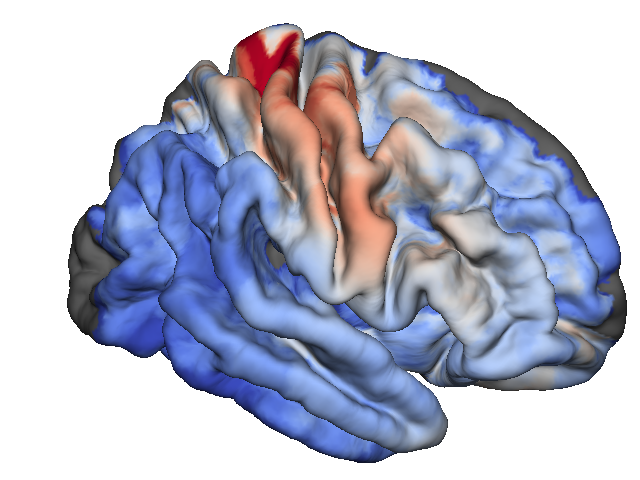

In [14]:
plot_average_values('avg')

### Bipolar Reference

/home/gio/tools/phypno/phypno/attr/anat.py:84: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  pos[2] + neighb[p, 2]]
INFO:lmer:LMER summary
INFO:lmer:inferiortemporal               coef=0.566  p=0.0001
INFO:lmer:superiortemporal               coef=0.597  p=0.0000
INFO:lmer:inferiorparietal               coef=0.604  p=0.0023
INFO:lmer:middletemporal                 coef=0.613  p=0.0000
INFO:lmer:supramarginal                  coef=0.638  p=0.0030
INFO:lmer:precentral                     coef=0.664  p=0.0023
INFO:lmer:                               coef=0.801
INFO:lmer:rostralmiddlefrontal           coef=0.993  p=0.0001
INFO:lmer:parsorbitalis                  coef=1.047  p=0.0006
INFO:lmer:caudalmiddlefrontal            coef=1.087  p=0.0000


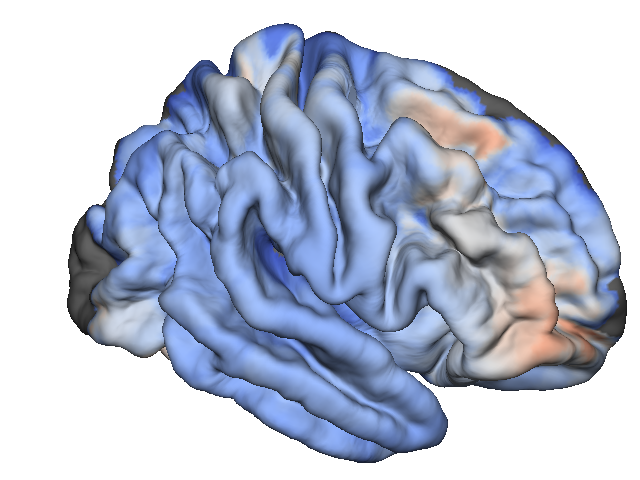

/home/gio/tools/venv/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/gio/tools/venv/lib/python3.4/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:lmer:LMER summary
INFO:lmer:superiorfrontal                coef=1.096  p=0.0004
INFO:lmer:middletemporal                 coef=1.232  p=0.0007
INFO:lmer:                               coef=1.268
INFO:lmer:superiortemporal               coef=1.290  p=0.0454
INFO:lmer:rostralmiddlefrontal           coef=1.301  p=0.0107
INFO:lmer:precentral                     coef=1.319  p=0.0000
INFO:lmer:postcentral                    coef=1.333  p=0.0000
/home/gio/projects/spgr/scripts/spgr/plot_spindles.py:79: RuntimeWarning: invalid value encountered in less
  x.data[0][x.data[0] < threshold[0]] = NaN
/home/gio/projects/spgr/scripts/spgr/plot_spindles.py:81: R

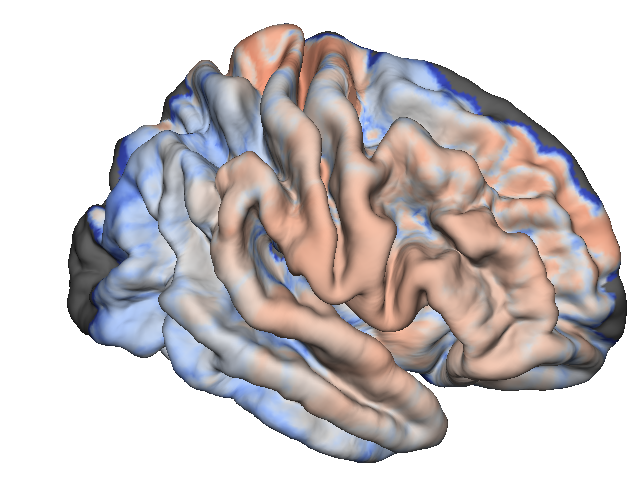

/home/gio/tools/venv/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/gio/tools/venv/lib/python3.4/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:lmer:LMER summary
INFO:lmer:insula                         coef=16.592  p=0.0000
INFO:lmer:postcentral                    coef=49.442  p=0.0000
INFO:lmer:superiortemporal               coef=49.871  p=0.0000
INFO:lmer:parsopercularis                coef=50.122  p=0.0062
INFO:lmer:precentral                     coef=53.296  p=0.0077
INFO:lmer:                               coef=59.462
INFO:lmer:lateralorbitofrontal           coef=69.629  p=0.0092
INFO:lmer:lateraloccipital               coef=76.756  p=0.0318
INFO:lmer:superiorfrontal                coef=80.705  p=0.0318
INFO:lmer:medialorbitofrontal            coef=108.449  p=0.0000
/home/gio/proj

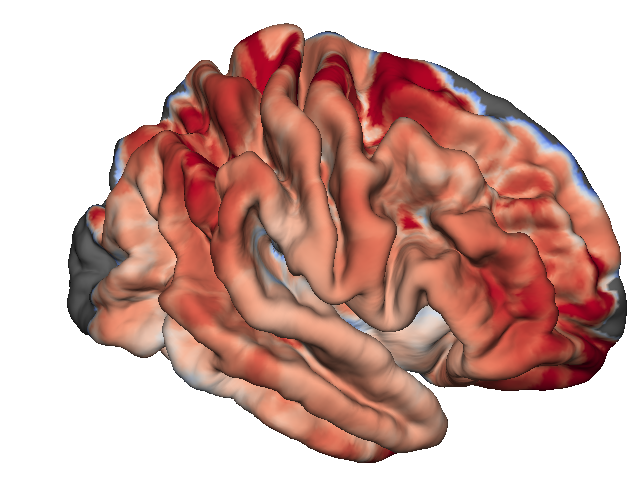

/home/gio/tools/venv/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/gio/tools/venv/lib/python3.4/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:lmer:LMER summary
INFO:lmer:inferiortemporal               coef=11.206  p=0.0000
INFO:lmer:inferiorparietal               coef=11.436  p=0.0000
INFO:lmer:middletemporal                 coef=11.473  p=0.0000
INFO:lmer:superiortemporal               coef=11.634  p=0.0001
INFO:lmer:                               coef=11.887
INFO:lmer:rostralmiddlefrontal           coef=12.159  p=0.0004
INFO:lmer:caudalmiddlefrontal            coef=12.224  p=0.0004
INFO:lmer:precentral                     coef=12.258  p=0.0000
INFO:lmer:postcentral                    coef=12.629  p=0.0000
INFO:lmer:superiorfrontal                coef=12.650  p=0.0131
INFO:lmer:super

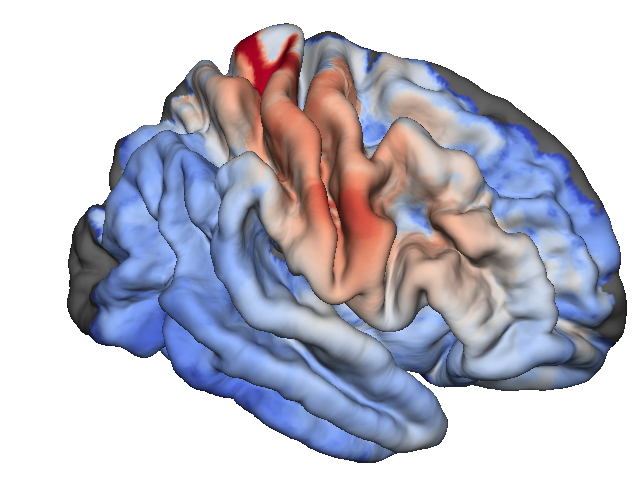

In [15]:
plot_average_values(15)